##### COORESPONDANCE DES FICHIERS COLLECTES

In [58]:
import pandas as pd
from datetime import datetime, timedelta
import os, sys
import numpy as np
import re
from sqlalchemy import create_engine
import logging
import matplotlib.pyplot as plt
import statistics as st
import calendar

In [10]:
panier_df = pd.read_excel("Echantillon_Data_Scrapping_09032024_valide_code.xlsx")
panier_df.head()

len(panier_df)

1458

##### COORESPONDANCE AVEC LE PANIER DE BIEN

In [11]:
colonnes_a_comparer = ["Libelle_du_produit"] 

date_debut = datetime.strptime("01-07-2024", "%d-%m-%Y")  
date_fin = datetime.strptime("31-07-2024", "%d-%m-%Y")  
# Traiter les intervalles de prix pour obtenir le plus petit prix
def extract_min_price(value):
    """
    Extraire la valeur de gauche dans l'interval.
    """
    if isinstance(value, str):
        if "-" in value:
            parts = value.split("-")
            if len(parts) >= 2:
                return int(parts[0].strip())
        elif " " in value:
            return int(value.split()[0])
    return value

def extraction_nom_site(url):
    """
    Extrait le nom du site d'une URL complète.
    """
    sites = ['auchan', 'kevajo', 'ivoirshop']
    
    for site in sites:
        if site in url:
            return site
        
    return None

while date_debut <= date_fin:
    date_str = date_debut.strftime("%d%m%Y")
    fichier_journalier = os.path.join("Data_Collecte","juillet", f"Data_Scrapping_{date_str}.xlsx")
    try:
        df_journalier = pd.read_excel(fichier_journalier)
        
        lignes_correspondantes = pd.merge(df_journalier, panier_df[['Libelle_du_produit', 'Code produit', 'Code']], how="inner", on=colonnes_a_comparer)

        lignes_correspondantes['Code_site'] = lignes_correspondantes['Code_site'].apply(lambda x: extraction_nom_site(str(x)) if pd.notnull(x) and x != 'adjovan' else x)
        lignes_correspondantes['Code_site'].fillna('adjovan', inplace=True)

        lignes_correspondantes["Prix_du_produit"] = lignes_correspondantes["Prix_du_produit"].fillna("")
        lignes_correspondantes["Prix_du_produit"] = lignes_correspondantes["Prix_du_produit"].apply(lambda x: x.replace(".", "") if isinstance(x, str) else x)
        lignes_correspondantes["Prix_du_produit"] = lignes_correspondantes["Prix_du_produit"].apply(lambda x: x.replace(",", "") if isinstance(x, str) else x)
        #lignes_correspondantes["Prix_du_produit"] = pd.to_numeric(lignes_correspondantes["Prix_du_produit"].str.replace("[^\d-]", "", regex=True), errors='coerce')
        #lignes_correspondantes["Prix_du_produit"] = lignes_correspondantes["Prix_du_produit"].apply(lambda x: float(x.split("-")[0]) if isinstance(x, str) and "-" in x else x)
        lignes_correspondantes["Prix_du_produit"] = lignes_correspondantes["Prix_du_produit"].apply(extract_min_price)
        
        fichier_sortie = os.path.join("Data_Valide_Prix","juillet",f"Data_Scrapping_{date_str}.xlsx")
        lignes_correspondantes.to_excel(fichier_sortie, index=False)
        
    except FileNotFoundError:
        print(f"Le fichier {fichier_journalier} n'existe pas.")
 
    date_debut += timedelta(days=1)

Le fichier Data_Collecte\juillet\Data_Scrapping_01072024.xlsx n'existe pas.
Le fichier Data_Collecte\juillet\Data_Scrapping_02072024.xlsx n'existe pas.
Le fichier Data_Collecte\juillet\Data_Scrapping_03072024.xlsx n'existe pas.
Le fichier Data_Collecte\juillet\Data_Scrapping_04072024.xlsx n'existe pas.
Le fichier Data_Collecte\juillet\Data_Scrapping_05072024.xlsx n'existe pas.
Le fichier Data_Collecte\juillet\Data_Scrapping_06072024.xlsx n'existe pas.
Le fichier Data_Collecte\juillet\Data_Scrapping_07072024.xlsx n'existe pas.
Le fichier Data_Collecte\juillet\Data_Scrapping_08072024.xlsx n'existe pas.
Le fichier Data_Collecte\juillet\Data_Scrapping_13072024.xlsx n'existe pas.
Le fichier Data_Collecte\juillet\Data_Scrapping_14072024.xlsx n'existe pas.
Le fichier Data_Collecte\juillet\Data_Scrapping_19072024.xlsx n'existe pas.
Le fichier Data_Collecte\juillet\Data_Scrapping_25072024.xlsx n'existe pas.
Le fichier Data_Collecte\juillet\Data_Scrapping_27072024.xlsx n'existe pas.
Le fichier D

##### AJOUT DES TYPES DE VARIETE AUX COLLECTES JOURNALIERES

In [12]:
panier_df2 = pd.read_excel("Panier_renomme.xlsx")
def clean_and_convert(value):
    if pd.isna(value):
        return np.nan
    elif isinstance(value, (int, float)):
        return int(value)  
    elif isinstance(value, str):
        try:
            numeric_part = re.search(r'\d+', value).group()  
            return int(numeric_part) 
        except (TypeError, AttributeError, ValueError):
            return np.nan  
'''  
def mean_ignore_nan(values):
    if values.isnull().all():
        return np.nan
    return np.nanmean(values)
'''

date_debut = datetime.strptime("01-07-2024", "%d-%m-%Y")  
date_fin = datetime.strptime("31-07-2024", "%d-%m-%Y")

while date_debut <= date_fin:
    date_str = date_debut.strftime("%d%m%Y")
    fichier_journalier = os.path.join("Data_Valide_Prix","juillet", f"Data_Scrapping_{date_str}.xlsx")
    try:
        df_journalier = pd.read_excel(fichier_journalier)
        
        df_journalier['Prix_du_produit'] = df_journalier['Prix_du_produit'].apply(clean_and_convert)
        df_journalier['Unite_monetaire'] ='CFA'
        #df_journalier['Date_de_collecte'] = pd.to_datetime(df_journalier['Date_de_collecte'])
        premiere_date = df_journalier.loc[0, 'Date_de_collecte'].split()[0]
        df_journalier['Date_de_collecte'] = premiere_date
        #donnees_groupees = df_journalier.groupby(['Date_de_collecte','Unite_monetaire','Libelle_du_produit']).agg({'Prix_du_produit': 'mean'}).reset_index()
        donnees_groupees2 = pd.merge(df_journalier, panier_df2[['Code produit','Type variété (HE, O1,O2,O3)']], how="inner", on="Code produit")
        #donnees_groupees = df_journalier.groupby(['Date_de_collecte', 'Unite_monetaire', 'Code produit']).agg({'Prix_du_produit': mean_ignore_nan}).reset_index()
        #print(f"Data_Scrapping_{date_str}.xlsx")
        fichier_sortie = os.path.join("Data_correction1","juillet",f"Data_Scrapping_{date_str}.xlsx")
        donnees_groupees2.to_excel(fichier_sortie, index=False)
            
    except FileNotFoundError:
        print(f"Le fichier {fichier_journalier} n'existe pas.")
 
    date_debut += timedelta(days=1)

Le fichier Data_Valide_Prix\juillet\Data_Scrapping_01072024.xlsx n'existe pas.
Le fichier Data_Valide_Prix\juillet\Data_Scrapping_02072024.xlsx n'existe pas.
Le fichier Data_Valide_Prix\juillet\Data_Scrapping_03072024.xlsx n'existe pas.
Le fichier Data_Valide_Prix\juillet\Data_Scrapping_04072024.xlsx n'existe pas.
Le fichier Data_Valide_Prix\juillet\Data_Scrapping_05072024.xlsx n'existe pas.
Le fichier Data_Valide_Prix\juillet\Data_Scrapping_06072024.xlsx n'existe pas.
Le fichier Data_Valide_Prix\juillet\Data_Scrapping_07072024.xlsx n'existe pas.
Le fichier Data_Valide_Prix\juillet\Data_Scrapping_08072024.xlsx n'existe pas.
Le fichier Data_Valide_Prix\juillet\Data_Scrapping_13072024.xlsx n'existe pas.
Le fichier Data_Valide_Prix\juillet\Data_Scrapping_14072024.xlsx n'existe pas.
Le fichier Data_Valide_Prix\juillet\Data_Scrapping_19072024.xlsx n'existe pas.
Le fichier Data_Valide_Prix\juillet\Data_Scrapping_25072024.xlsx n'existe pas.
Le fichier Data_Valide_Prix\juillet\Data_Scrapping_2

##### FUSION ET AGGREGATION DES DONNEES DU MOIS PRECEDENT(Mars)

In [23]:
#FUSION DE TOUS LES FICHIERS DU MOIS PRECEDENT
dossier = os.path.join("Data_correction1","mars")
dfs = []

for fichier in os.listdir(dossier):
        
        chemin_complet = os.path.join(dossier, fichier)
        df = pd.read_excel(chemin_complet)
        dfs.append(df)

df_final = pd.concat(dfs, ignore_index=True)

path_out = os.path.join("Data_correction1","mars","F_Data_Scrapping_Mars.xlsx")
df_final.to_excel(path_out, index=False)


In [34]:
#Interchangement des colonnes "Date_de_collecte" et "Code_site"
path_out1 = os.path.join("Data_correction1","mars","F_Data_Scrapping_Mars.xlsx")
df = pd.read_excel(path_out1)
columns1 = list(df.columns)
columns1[columns1.index('Date_de_collecte')], columns1[columns1.index('Code_site')] = columns1[columns1.index('Code_site')], columns1[columns1.index('Date_de_collecte')]
df = df[columns1]

,Date_de_collecte,Code_site,Libelle_du_produit,Quantite,Prix_du_produit,Caracteristique,Unite,Unite_monetaire,Code produit,Code,"Type variété (HE, O1,O2,O3)"
0,2024-03-01,ivoirshop,Thé Homme Fort – Performance Au Lit – Virilité...,Status:In stock,7500.0,NaN,NaN,CFA,1020100030701,111111,Homogene
1,2024-03-01,ivoirshop,Thé Homme Fort – Performance Au Lit – Virilité...,Status:In stock,7500.0,NaN,NaN,CFA,1020100030701,111111,Homogene
2,2024-03-01,ivoirshop,Thé Homme Fort – Performance Au Lit – Virilité...,Status:In stock,7500.0,NaN,NaN,CFA,1020100030701,111111,Homogene
3,2024-03-01,ivoirshop,Thé Homme Fort – Performance Au Lit – Virilité...,Status:In stock,7500.0,NaN,NaN,CFA,1020100030701,111111,Homogene
4,2024-03-01,ivoirshop,1 Paquet Thé victoria – Moringa – 25 Sachets,Status:4 en stock,NaN,NaN,NaN,CFA,1020100030701,111111,Homogene


In [6]:
#AGGREGATION DES DONNEES DU FICHIER DU MOIS PAR PRIX ET AJOUT DE LA COLONNE "FOURCHETTE"(Pour le mois de référence)

# Calculer les fourchettes pour chaque produit
def calculate_price_ranges(row):
    price = row['Prix_du_produit']
    
    if row['Type variété (HE, O1,O2,O3)'] == 'Heterogene':
        lower_bound = price * 0.85
        upper_bound = price * 1.15
    elif row['Type variété (HE, O1,O2,O3)'] == 'Homogene':
        lower_bound = price * 0.70
        upper_bound = price * 1.30
    else:
        raise ValueError(f"Variété non reconnue pour le produit {row['Libelle_du_produit']}")
    
    return f"{lower_bound:.2f}-{upper_bound:.2f}"

path1 = os.path.join("Data_correction1","mars","F_Data_Scrapping_Mars.xlsx")
df_FDSM = pd.read_excel(path1)
df_FDSM['Unite_monetaire'] ='CFA'
premiere_date = df_FDSM.loc[0, 'Date_de_collecte'].split()[0]
df_FDSM['Date_de_collecte'] = premiere_date
df_FDSM_A = df_FDSM.groupby(['Date_de_collecte','Code_site','Libelle_du_produit','Code produit','Unite_monetaire','Type variété (HE, O1,O2,O3)']).agg({'Prix_du_produit': 'mean'}).reset_index()
df_FDSM_A['fourchette'] =df_FDSM_A.apply(calculate_price_ranges, axis=1)
path_out = os.path.join("Data_correction1","mars","A_Data_Scrapping_Avril.xlsx")
df_FDSM_A.to_excel(path_out, index=False)

In [13]:
# AJOUT DE LA COLONNE "FOURCHETTE"(pour les autres mois)

# Calculer les fourchettes pour chaque produit
def calculate_price_ranges(row):
    price = row['Prix_du_produit']
    
    if row['Type variété (HE, O1,O2,O3)'] == 'Heterogene':
        lower_bound = price * 0.85
        upper_bound = price * 1.15
    elif row['Type variété (HE, O1,O2,O3)'] == 'Homogene':
        lower_bound = price * 0.70
        upper_bound = price * 1.30
    else:
        raise ValueError(f"Variété non reconnue pour le produit {row['Libelle_du_produit']}")
    
    return f"{lower_bound:.2f}-{upper_bound:.2f}"

path1 = os.path.join("dossier_imputation","juin","A_Data_Scrapping_juin.xlsx")
df_FDSM = pd.read_excel(path1)
df_FDSM['fourchette'] =df_FDSM.apply(calculate_price_ranges, axis=1)
path_out = os.path.join("Data_correction1","juin","A_Data_Scrapping_juin.xlsx")
df_FDSM_A.to_excel(path_out, index=False)

##### CORRECTION 

##### Control sur les prix selon la fourchette attribuée à la variété

In [14]:
#VERSION1
previous_month_file = os.path.join("Data_correction1","juin","A_Data_Scrapping_juin.xlsx")

aggregated_df = pd.read_excel(previous_month_file)

# Créer un dictionnaire pour un accès rapide aux fourchettes
price_ranges = {}

for _, row in aggregated_df.iterrows():
    lower_bound, upper_bound = map(float, row['fourchette'].split('-')) 
    price_ranges[row['Libelle_du_produit']] = (lower_bound, upper_bound)

# Fonction pour vérifier si le prix est dans la fourchette
def is_within_range(product, price):
    if product not in price_ranges:
        return None
    lower_bound, upper_bound = price_ranges[product]
    return lower_bound <= price <= upper_bound

daily_files_directory= os.path.join("Data_correction1","juillet")

# Parcourir chaque fichier journalier
for daily_file in os.listdir(daily_files_directory):
    if daily_file.endswith('.xlsx') : 
        daily_file_path = os.path.join(daily_files_directory, daily_file)
        daily_df = pd.read_excel(daily_file_path)
        daily_df['status'] = None
        daily_df['Valeur_Atypique'] = None

        # Créer une liste des lignes à conserver
        rows_to_keep = []

        for _, row in daily_df.iterrows():
            product = row['Libelle_du_produit']
            if product in price_ranges:
                price = row['Prix_du_produit']
                if pd.notna(price) and not is_within_range(product, price):
                    row['Prix_du_produit'] = None
                rows_to_keep.append(row)
            else:
                # Produit non présent dans le fichier du mois précédent
                continue

        # Convertir la liste des lignes à conserver en DataFrame
        cleaned_df = pd.DataFrame(rows_to_keep, columns=daily_df.columns)

        cleaned_file_path = os.path.join("Data_Correction2","juillet",daily_file)
        cleaned_df.to_excel(cleaned_file_path, index=False)


In [15]:
#MISE A JOUR DU PROGRAMME DE CORRECTION DES PRIX : VERSION2
previous_month_file = os.path.join("Data_correction1","juin","A_Data_Scrapping_juin.xlsx")

aggregated_df = pd.read_excel(previous_month_file)

# Créer un dictionnaire pour un accès rapide aux fourchettes
price_ranges = {}

for _, row in aggregated_df.iterrows():
    lower_bound, upper_bound = map(float, row['fourchette'].split('-')) 
    price_ranges[row['Libelle_du_produit']] = (lower_bound, upper_bound)

# Fonction pour vérifier si le prix est dans la fourchette
def is_within_range(product, price):
    if product not in price_ranges:
        return None
    lower_bound, upper_bound = price_ranges[product]
    return lower_bound <= price <= upper_bound

daily_files_directory= os.path.join("Data_correction1","juillet")

# Parcourir chaque fichier journalier
for daily_file in os.listdir(daily_files_directory):
    if daily_file.endswith('.xlsx') : 
        daily_file_path = os.path.join(daily_files_directory, daily_file)
        daily_df = pd.read_excel(daily_file_path)
        daily_df['Status'] = None
        daily_df['Valeur_Atypique'] = None

        # Créer une liste des lignes à conserver
        rows_to_keep = []

        for _, row in daily_df.iterrows():
            product = row['Libelle_du_produit']
            if product in price_ranges:
                price = row['Prix_du_produit']
                if pd.isna(price):
                    row['Status'] = 'Missing'
                elif not is_within_range(product, price):
                    row['Status'] = 'Atypique'
                    row['Valeur_Atypique'] = f"Valeur atypique:{price}"
                    row['Prix_du_produit'] = None 
                else:
                    row['Status'] = 'Valide'
                rows_to_keep.append(row)
            else:
                # Produit non présent dans le fichier du mois précédent
                continue

        cleaned_df = pd.DataFrame(rows_to_keep, columns=daily_df.columns)

        cleaned_file_path = os.path.join("Data_Correction2","juillet",daily_file)
        cleaned_df.to_excel(cleaned_file_path, index=False)


##### TRIATEMENT D'IMPUTATION DES PRIX MANQUANTS

In [16]:
#MISE A JOUR DU PROGRAMME D'IMPUTATION DES PRIX
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

#logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levellevel)s - %(message)s')

fichier_mois_precedent = os.path.join("Data_correction1", "juin", "A_Data_Scrapping_juin.xlsx")
df_mois_precedent = pd.read_excel(fichier_mois_precedent)

logging.info("Fichier agrégé du mois précédent chargé.")

# Fonction pour l'imputation des prix manquants
def imputer_prix_manquants(df_journalier, df_mois_precedent):
    for index, row in df_journalier.iterrows():
        if pd.isna(row["Prix_du_produit"]):
            produit = row["Libelle_du_produit"]
            site = row["Code_site"]
            
            ligne_prix_precedent = df_mois_precedent[(df_mois_precedent["Libelle_du_produit"] == produit) & (df_mois_precedent["Code_site"] == site)]
            if not ligne_prix_precedent.empty:
                prix_precedent = ligne_prix_precedent["Prix_du_produit"].values[0]
                variete = ligne_prix_precedent["Type variété (HE, O1,O2,O3)"].values[0]
                
                # Filtrer les produits de la même variété dans le fichier journalier
                produits_meme_variete = df_journalier[(df_journalier["Type variété (HE, O1,O2,O3)"] == variete) & (df_journalier["Code_site"] == site)]
                # Exclure les produits avec des prix manquants
                produits_meme_variete = produits_meme_variete.dropna(subset=["Prix_du_produit"])
                
                if not produits_meme_variete.empty:
                    # Calculer les variations individuelles de chaque produit de la même variété
                    taux_variations = []
                    for _, ligne_meme_variete in produits_meme_variete.iterrows():
                        produit_meme_variete = ligne_meme_variete["Libelle_du_produit"]
                        ligne_prix_meme_variete_precedent = df_mois_precedent[(df_mois_precedent["Libelle_du_produit"] == produit_meme_variete) & (df_mois_precedent["Code_site"] == site)]
                        if not ligne_prix_meme_variete_precedent.empty:
                            prix_meme_variete_precedent = ligne_prix_meme_variete_precedent["Prix_du_produit"].values[0]
                            prix_actuel = ligne_meme_variete["Prix_du_produit"]
                            taux_variation = (prix_actuel - prix_meme_variete_precedent) / prix_meme_variete_precedent
                            taux_variations.append(taux_variation)
                    
                    # Calculer la variation moyenne
                    if taux_variations:
                        variation_moyenne_taux = st.mean(taux_variations)
                        # Appliquer la variation moyenne en pourcentage au prix du mois précédent
                        nouveau_prix = prix_precedent * (1 + variation_moyenne_taux)
                        df_journalier.at[index, "Prix_du_produit"] = nouveau_prix
                        logging.info(f"Imputation faite pour {produit} avec le nouveau prix {nouveau_prix}.")
                else:
                    logging.info(f"Aucun produit similaire trouvé pour la variété {variete}.")
            else:
                logging.info(f"le produit {produit} n'est pas parmi ceux du mois précédent.")

dossier_fichiers_journaliers = os.path.join("Data_Correction2", "juillet")
dossier_sortie = "dossier_imputation"

if not os.path.exists(dossier_sortie):
    os.makedirs(dossier_sortie)

logging.info("Début du traitement des fichiers journaliers.")

for nom_fichier in os.listdir(dossier_fichiers_journaliers):
    if nom_fichier.endswith(".xlsx"):
        chemin_fichier_journalier = os.path.join(dossier_fichiers_journaliers, nom_fichier)
        df_journalier = pd.read_excel(chemin_fichier_journalier)

        logging.info(f"Traitement du fichier {nom_fichier}.")

        imputer_prix_manquants(df_journalier, df_mois_precedent)
        
        chemin_fichier_corrige = os.path.join(dossier_sortie,"juillet",nom_fichier)
        df_journalier.to_excel(chemin_fichier_corrige, index=False)

logging.info("Traitement terminé.")


2024-08-11 19:51:28,215 - INFO - Fichier agrégé du mois précédent chargé.
2024-08-11 19:51:28,215 - INFO - Début du traitement des fichiers journaliers.
2024-08-11 19:51:28,583 - INFO - Traitement du fichier Data_Scrapping_09072024.xlsx.
2024-08-11 19:51:28,766 - INFO - Imputation faite pour Beurre doux gastronomique avec le nouveau prix 4853.171146326329.
2024-08-11 19:51:28,963 - INFO - Imputation faite pour Beurre doux gastronomique avec le nouveau prix 4853.171146326329.
2024-08-11 19:51:29,146 - INFO - Imputation faite pour Beurre doux gastronomique avec le nouveau prix 4853.171146326329.
2024-08-11 19:51:29,347 - INFO - Imputation faite pour Beurre doux gastronomique avec le nouveau prix 4853.171146326329.
2024-08-11 19:51:29,529 - INFO - Imputation faite pour Beurre doux gastronomique avec le nouveau prix 4853.171146326329.
2024-08-11 19:51:29,727 - INFO - Imputation faite pour Beurre doux gastronomique avec le nouveau prix 4853.171146326329.
2024-08-11 19:51:29,921 - INFO - Imp

##### CALCUL DE L'INDICE

##### Fusion et Aggregation des données du mois en cours

In [4]:
#FUSION DE TOUS LES FICHIERS DU MOIS EN COURS
dossier = os.path.join("dossier_imputation","juin")
dfs = []

for fichier in os.listdir(dossier):
        
        chemin_complet = os.path.join(dossier, fichier)
        df = pd.read_excel(chemin_complet)
        dfs.append(df)

df_final = pd.concat(dfs, ignore_index=True)

path_out = os.path.join("dossier_imputation","juin","F_Data_Scrapping_juin.xlsx")
df_final.to_excel(path_out, index=False)

In [41]:
#FUSION DE TOUS LES FICHIERS DU MOIS EN COURS
dossier = os.path.join("dossier_imputation","mai")
dfs = []

for fichier in os.listdir(dossier):
        
        chemin_complet = os.path.join(dossier, fichier)
        df = pd.read_excel(chemin_complet)
        dfs.append(df)

df_FDSM = pd.concat(dfs, ignore_index=True)

#AGGREGATION DE TOUS LES FICHIERS DU MOIS EN COURS
#df_FDSM = pd.read_excel(df_final)
df_FDSM['Unite_monetaire'] ='CFA'
df_FDSM['Prix_du_produit'] = pd.to_numeric(df_FDSM['Prix_du_produit'], errors='coerce')
df_FDSM_valide = df_FDSM.dropna(subset=['Prix_du_produit'])
df_FDSM_A = df_FDSM_valide.groupby(['Code_site','Libelle_du_produit','Unite_monetaire','Code produit','Type variété (HE, O1,O2,O3)']).agg({'Prix_du_produit': 'mean'}).reset_index()
#df_FDSM_A['fourchette'] =df_FDSM_A.apply(calculate_price_ranges, axis=1)
path_out = os.path.join("dossier_imputation","mai","A_Data_Scrapping_mai.xlsx")
df_FDSM_A.to_excel(path_out, index=False)

In [5]:
#AGGREGATION DES DONNES DU MOIS EN COURS
'''
def calculate_price_ranges(row):
    price = row['Prix_du_produit']
    
    if row['Type variété (HE, O1,O2,O3)'] == 'Heterogene':
        lower_bound = price * 0.85
        upper_bound = price * 1.15
    elif row['Type variété (HE, O1,O2,O3)'] == 'Homogene':
        lower_bound = price * 0.70
        upper_bound = price * 1.30
    else:
        raise ValueError(f"Variété non reconnue pour le produit {row['Libelle_du_produit']}")
    
    return f"{lower_bound:.2f}-{upper_bound:.2f}"
'''

path2 = os.path.join("dossier_imputation","juin","F_Data_Scrapping_juin.xlsx")
df_FDSM = pd.read_excel(path2)
df_FDSM['Unite_monetaire'] ='CFA'
df_FDSM['Prix_du_produit'] = pd.to_numeric(df_FDSM['Prix_du_produit'], errors='coerce')
df_FDSM_valide = df_FDSM.dropna(subset=['Prix_du_produit'])
df_FDSM_A = df_FDSM_valide.groupby(['Code_site','Libelle_du_produit','Unite_monetaire','Code produit','Type variété (HE, O1,O2,O3)']).agg({'Prix_du_produit': 'mean'}).reset_index()
#df_FDSM_A['fourchette'] =df_FDSM_A.apply(calculate_price_ranges, axis=1)
path_out = os.path.join("dossier_imputation","juin","A_Data_Scrapping_juin.xlsx")
df_FDSM_A.to_excel(path_out, index=False)

##### Traitement personnel

In [41]:
#AFFICHAGE DU NOMBRE DE PRODUIT PAR VARIETE
#fichier_agrege_mois = os.path.join("dossier_imputation","Avril","A_Data_Scrapping_Avril.xlsx")
df_agrege_mois = pd.read_excel("pondération produit alimentaire panier IHPC.xlsx")
#df_agrege_mois = pd.read_excel("nommenclature IHPC ITS.xlsx", sheet_name="ex_var_CIV")

#Convertir la colonne 'Code produit' en chaînes (string)
df_agrege_mois['Code produit'] = df_agrege_mois['Code produit'].astype(str)

df_agrege_mois = df_agrege_mois[df_agrege_mois['Code produit'].str.startswith(('10', '20'))]
df_agrege_mois['Code produit'] = df_agrege_mois['Code produit'].astype(str).str.slice(stop=-2)
grouped_count = df_agrege_mois.groupby('Code produit').size().reset_index(name='count')
#df_agrege_mois = df_agrege_mois.groupby('Code produit')['Moyenne_Prix_Produits'].count().reset_index()
#distinct_codes = df_agrege_mois["Code variété"].unique()
#val = df_agrege_mois["Code produit"].nunique()
grouped_count.to_excel("POIDS_SIAKA.xlsx", index=False)

#grouped_count.head(100)

In [ ]:
df_agrege_mois = pd.read_excel("pondération produit alimentaire panier IHPC.xlsx")
df_agrege_mois['code var 2014'] = df_agrege_mois['code var 2014'].astype(str)

df_agrege_mois = df_agrege_mois[df_agrege_mois['code var 2014'].str.startswith(('10', '20'))]
df_agrege_mois['code var 2014'] = df_agrege_mois['code var 2014'].astype(str).str.slice(stop=-2)

moyenne_prix_produits = df_agrege_mois.groupby('code var 2014')['pond var'].mean().reset_index()
moyenne_prix_produits.columns = ['Code produit', 'somme_pond']

moyenne_prix_produits.head(100)

In [ ]:
# Convertir la colonne 'Code produit' en chaînes (string)
df_agrege_mois['Code produit'] = df_agrege_mois['Code produit'].astype(str)

df_agrege_mois = df_agrege_mois[df_agrege_mois['Code produit'].str.startswith(('10', '20'))]
df_agrege_mois['Code produit'] = df_agrege_mois['Code produit'].astype(str).str.slice(stop=-12)
distinct_codes = df_agrege_mois["Code produit"].unique()
val = df_agrege_mois["Code produit"].nunique()
print(val)

In [ ]:
#compte_code_produit = df_agrege_mois['Code produit'].value_counts()
#cp_distinct = df_agrege_mois["Code produit"].nunique()
distinct_codes = df_agrege_mois["Code produit"].unique()
df_distinct_codes = pd.DataFrame(distinct_codes, columns=["Code produit"])
df_distinct_codes.to_excel("Les_Variete.xlsx",index=False)

In [83]:
#AFFICHAGE DU NOMBRE DE PRODUIT PAR VARIETE
#fichier_agrege_mois = os.path.join("dossier_imputation","Avril","A_Data_Scrapping_Avril.xlsx")
path12 = os.path.join("dossier_imputation", "juillet",'A_Data_Scrapping_juillet.xlsx')
df_agrege_mois = pd.read_excel(path12)
#df_agrege_mois = pd.read_excel("nommenclature IHPC ITS.xlsx", sheet_name="ex_var_CIV")

#Convertir la colonne 'Code produit' en chaînes (string)
df_agrege_mois['Code produit'] = df_agrege_mois['Code produit'].astype(str)

df_agrege_mois = df_agrege_mois[df_agrege_mois['Code produit'].str.startswith(('10', '20'))]
df_agrege_mois['Code produit'] = df_agrege_mois['Code produit'].astype(str).str.slice(stop=-4)
#grouped_count = df_agrege_mois.groupby('Code produit').size().reset_index(name='count')
moyenne_prix_produits = df_agrege_mois.groupby('Code produit')['Prix_du_produit'].mean().reset_index()
#df_agrege_mois = df_agrege_mois.groupby('Code produit')['Moyenne_Prix_Produits'].count().reset_index()
#distinct_codes = df_agrege_mois["Code variété"].unique()
#val = df_agrege_mois["Code produit"].nunique()
path12_out = os.path.join("dossier_imputation", "juillet",'A_Data_Scrapping_juillet.xlsx')
moyenne_prix_produits.to_excel(path12_out, index=False)

#grouped_count.head(100)

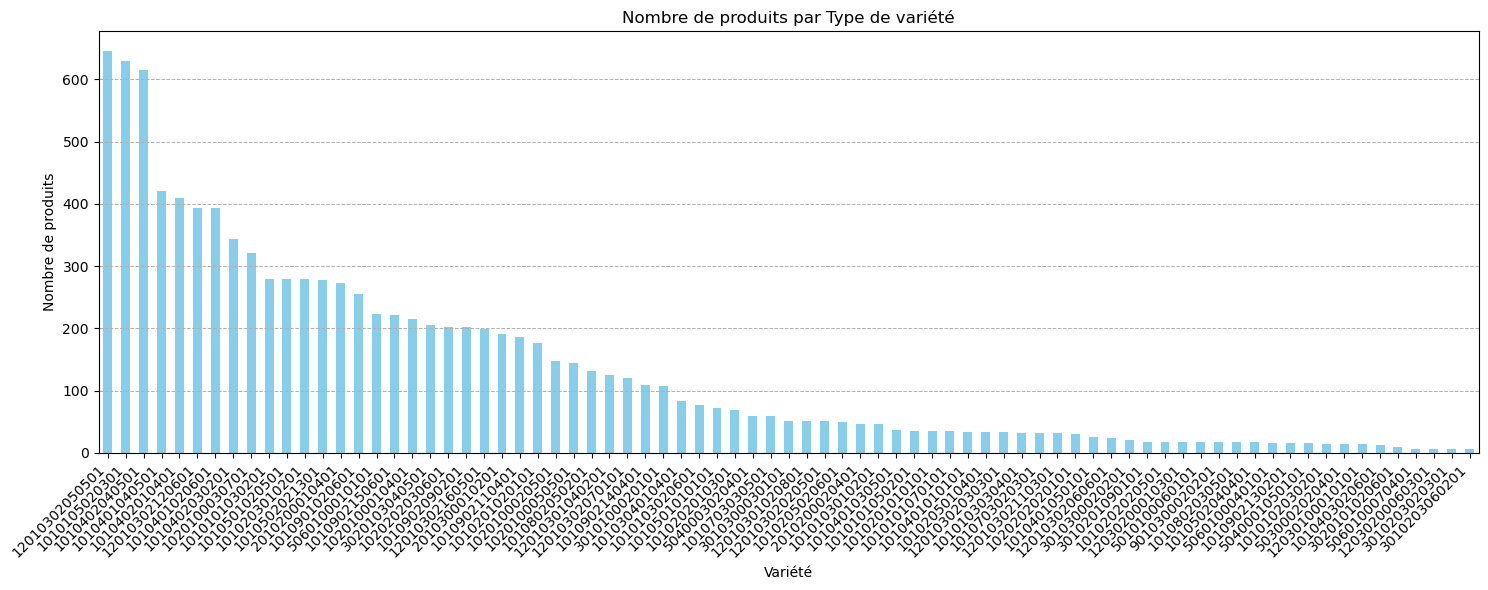

In [17]:
#AFFICHAGE DU NOMBRE DE PRODUIT PAR VARIETE
fichier_agrege_mois = os.path.join("dossier_imputation","A_Data_Scrapping_Avril.xlsx")
df_agrege_mois = pd.read_excel(fichier_agrege_mois)
compte_code_produit = df_agrege_mois['Code produit'].value_counts()


plt.figure(figsize=(15, 6))
compte_code_produit.plot(kind='bar', color='skyblue')
plt.title('Nombre de produits par Type de variété')
plt.xlabel('Variété')
plt.ylabel('Nombre de produits')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.xticks(rotation=45, ha='right') 
#plt.subplots_adjust(bottom=0.5) 
plt.tight_layout() 

plt.show()


In [12]:
# PRODUCTION DES PONDERATION

#Pondération Poste
path_pon = os.path.join("pondération produit alimentaire panier IHPC.xlsx")
pon = pd.read_excel(path_pon)
pon['code var 2014'] = pon['code var 2014'].astype(str).str.slice(stop=-2)
Indice_Post = pon.groupby('code var 2014')['pond var'].sum().reset_index()
Indice_Post.columns = ['Code_produit_poste', 'Pon_Poste']
Indice_Post.to_excel("Ponderation_Poste.xlsx", index=False)



#Pondération sous-groupe
path_pon = os.path.join("Ponderation_Poste.xlsx")
pon = pd.read_excel(path_pon)
pon['Code_produit_poste'] = pon['Code_produit_poste'].astype(str).str.slice(stop=-2)
Indice_Post = pon.groupby('Code_produit_poste')['Pon_Poste'].sum().reset_index()
Indice_Post.columns = ['Code_produit_SG', 'Pon_SG']
Indice_Post.to_excel("Ponderation_SG.xlsx", index=False)

#Pondération Groupe
path_pon = os.path.join("Ponderation_SG.xlsx")
pon = pd.read_excel(path_pon)
pon['Code_produit_SG'] = pon['Code_produit_SG'].astype(str).str.slice(stop=-2)
Indice_Post = pon.groupby('Code_produit_SG')['Pon_SG'].sum().reset_index()
Indice_Post.columns = ['Code_produit_groupe', 'Pon_groupe']
Indice_Post.to_excel("Ponderation_groupe.xlsx", index=False)

#Pondération Fonction
path_pon = os.path.join("Ponderation_groupe.xlsx")
pon = pd.read_excel(path_pon)
pon['Code_produit_groupe'] = pon['Code_produit_groupe'].astype(str).str.slice(stop=-2)
Indice_Post = pon.groupby('Code_produit_groupe')['Pon_groupe'].sum().reset_index()
Indice_Post.columns = ['Code_produit_fonction', 'Pon_fonction']
Indice_Post.to_excel("Ponderation_fonction.xlsx", index=False)

##### Calcul de L’indice de DUTOT (pour les variétés homogènes)

In [58]:
path2 = os.path.join("dossier_imputation", "mars","A_Data_Scrapping_Mars.xlsx")
df_FDSM_valide = pd.read_excel(path2)

df_ref = df_FDSM = pd.read_excel("Prix_Reference.xlsx")
df_ref['Code variete'] = df_ref['Code variete'].astype(str)

moyenne_prix_produits = df_FDSM_valide.groupby('Code produit')['Prix_du_produit'].mean().reset_index()
moyenne_prix_produits.columns = ['Code produit', 'Moyenne_Prix_Produits']
moyenne_prix_produits['Code produit'] = moyenne_prix_produits['Code produit'].astype(str).str.slice(stop=-4)

moyenne_prix_produits_tron = moyenne_prix_produits.groupby('Code produit')['Moyenne_Prix_Produits'].mean().reset_index()
#moyenne_prix_produits_tron.columns = ['Code produit', 'Moyenne_Prix_Produits']

#df_combined = pd.merge(moyenne_prix_produits, df_ref, on='Code produit')
df_combined = pd.merge(moyenne_prix_produits_tron, df_ref, left_on='Code produit', right_on='Code variete')
df_combined['Indice'] = df_combined['Moyenne_Prix_Produits'] / df_combined['prix de base']

out_final = os.path.join("dossier_imputation","mars","Indice_elementaire.xlsx")
df_combined.to_excel(out_final, index=False)


### Calcul de L’indice de Laspeyres 

##### pour les POSTES

In [59]:
Path_Indice_Elementaire = os.path.join("dossier_imputation","mars","Indice_elementaire.xlsx")
Indice_Elementaire = pd.read_excel(Path_Indice_Elementaire)
path_pon = os.path.join("pondération produit alimentaire panier IHPC.xlsx")
pon = pd.read_excel(path_pon)

df_post= pd.merge(Indice_Elementaire, pon, left_on='Code produit', right_on='code var 2014')

df_post['Produit'] = df_post['Indice'] * df_post['pond var']

df_post['Code produit'] = df_post['Code produit'].astype(str).str.slice(stop=-2)
#Indice_Post = df_post.groupby('Code produit')['Produit'].sum().reset_index()
Indice_Post = df_post.groupby('Code produit').apply(lambda x: x['Produit'].sum() / x['pond var'].sum()).reset_index()
Indice_Post.columns = ['Code_produit_poste', 'Indice_Poste']

out_final = os.path.join("dossier_imputation","mars","Indice_Poste.xlsx")

Indice_Post.to_excel(out_final, index=False)

##### pour les SOUS-GROUPES

In [60]:
Path_Indice_Poste = os.path.join("dossier_imputation","mars","Indice_Poste.xlsx")
Indice_Poste = pd.read_excel(Path_Indice_Poste)
path_pon = os.path.join("Ponderation_Poste.xlsx")
pon = pd.read_excel(path_pon)

df_post= pd.merge(Indice_Poste, pon, left_on='Code_produit_poste', right_on='Code_produit_poste')

df_post['Produit'] = df_post['Indice_Poste'] * df_post['Pon_Poste']

df_post['Code_produit_poste'] = df_post['Code_produit_poste'].astype(str).str.slice(stop=-2)
Indice_Post = df_post.groupby('Code_produit_poste')['Produit'].sum().reset_index()
Indice_Post = df_post.groupby('Code_produit_poste').apply(lambda x: x['Produit'].sum() / x['Pon_Poste'].sum()).reset_index()
Indice_Post.columns = ['Code_produit_SG', 'Indice_SG']

out_final = os.path.join("dossier_imputation","mars","Indice_SG.xlsx")

Indice_Post.to_excel(out_final, index=False)

##### pour les GROUPES

In [61]:
Path_Indice_SG = os.path.join("dossier_imputation","mars","Indice_SG.xlsx")
Indice_SG = pd.read_excel(Path_Indice_SG)
path_pon = os.path.join("Ponderation_SG.xlsx")
pon = pd.read_excel(path_pon)

df_post= pd.merge(Indice_SG , pon, left_on='Code_produit_SG', right_on='Code_produit_SG')

df_post['Produit'] = df_post['Indice_SG'] * df_post['Pon_SG']

df_post['Code_produit_SG'] = df_post['Code_produit_SG'].astype(str).str.slice(stop=-2)
#Indice_Post = df_post.groupby('Code_produit_SG')['Produit'].sum().reset_index()
Indice_Post = df_post.groupby('Code_produit_SG').apply(lambda x: x['Produit'].sum() / x['Pon_SG'].sum()).reset_index()
Indice_Post.columns = ['Code_produit_groupe', 'Indice_groupe']

out_final = os.path.join("dossier_imputation","mars","Indice_groupe.xlsx")

Indice_Post.to_excel(out_final, index=False)

##### pour les FONCTIONS

In [62]:
Path_Indice_G = os.path.join("dossier_imputation","mars","Indice_groupe.xlsx")
Indice_G = pd.read_excel(Path_Indice_G)
path_pon = os.path.join("ponderation_groupe.xlsx")
pon = pd.read_excel(path_pon)

df_post= pd.merge(Indice_G, pon, left_on='Code_produit_groupe', right_on='Code_produit_groupe')

df_post['Produit'] = df_post['Indice_groupe'] * df_post['Pon_groupe']

df_post['Code_produit_groupe'] = df_post['Code_produit_groupe'].astype(str).str.slice(stop=-2)
#Indice_Post = df_post.groupby('Code_produit_groupe')['Produit'].sum().reset_index()
Indice_Post = df_post.groupby('Code_produit_groupe').apply(lambda x: x['Produit'].sum() / x['Pon_groupe'].sum()).reset_index()
Indice_Post.columns = ['Code_produit_fonction', 'Indice_fonction']

out_final = os.path.join("dossier_imputation","mars","Indice_fonction.xlsx")

Indice_Post.to_excel(out_final, index=False)

#### STRCUTURE PUBLICATION IHPC

##### Pour les INDICES

In [57]:
#POUR LES INDICES
def generer_mois_list(annee, mois_debut=1, mois_fin=12):
    mois_list = []
    for mois in range(mois_debut, mois_fin + 1):
        mois_list.append(f'{mois:02}{annee}')
    return mois_list

def format_mois_annee(mois_annee):
    mois_num = int(mois_annee[:2])
    annee = mois_annee[2:]
    mois_nom = calendar.month_name[mois_num].lower()  
    return f'{mois_nom}_{annee}'

#Répertoire de base où se trouvent les dossiers mensuels
base_dir = 'dossier_imputation'


#code_libelle_df = pd.read_excel("nommenclature IHPC ITS.xlsx")

#Liste des mois (nom des dossiers)
mois_list = ['janvier','fevrier','mars', 'avril', 'mai', 'juin', 'juillet','aout','septembre','octobre','novembre','decembre']  

mois_list = generer_mois_list(2024)

#categories = ['Indice_elementaire', 'Indice_Poste', 'Indice_SG', 'Indice_groupe','Indice_fonction']

correspondance_path = 'nommenclature_IHPC_ITS_V2.xlsx'  # Remplacez par le nom de votre fichier

correspondance_dict = pd.read_excel(correspondance_path, sheet_name=None)

# Liste de catégories à traiter
categories = ['fonction','groupe','SG','Poste','elementaire']

#Dictionnaire pour stocker les DataFrames par catégorie
#data_dict = {cat: pd.DataFrame() for cat in categories}

data_dict = {cat: correspondance_dict[cat].copy() for cat in categories}

for mois in mois_list:
    mois_dir = os.path.join(base_dir, mois)
    
    for category in categories:
        file_path = os.path.join(mois_dir, f'Indice_{category}.xlsx')  
        
        if os.path.exists(file_path): 
            df = pd.read_excel(file_path)
            
            code_col = [col for col in df.columns if 'Code' in col and 'produit' in col]
            indice_col = [col for col in df.columns if 'Indice' in col]
            
            #On suppose que les fichiers contiennent une colonne 'Code' et une colonne 'Indice'
            df = df[[code_col[0], indice_col[0]]]
            df = df.rename(columns={code_col[0]: 'Code'})
            df = df.rename(columns={indice_col[0]: mois+'_2024'})  

            df[mois+'_2024'] = df[mois+'_2024'] * 100

            # Lire le DataFrame de correspondance pour la catégorie actuelle
            #correspondance_df = data_dict[category]

            #correspondance_df["Code"] = correspondance_df["Code"].astype(str)
            #df["Code"] = df["Code"].astype(str)
            #df.columns = df.columns.str.strip()
            data_dict[category].columns = data_dict[category].columns.str.strip()
   
             # Fusionner avec le DataFrame des libellés
            #df = pd.merge(df, correspondance_df, left_on='Code', right_on='Code', how='left')
            
            #Fusionner les données pour cette catégorie 
            if data_dict[category].empty:
                data_dict[category] = df
            else:
                data_dict[category] = pd.merge(data_dict[category], df, on='Code', how='left')

# Calcul des variations et ajout des colonnes de variation
for category, df in data_dict.items():
    mois_columns = [col for col in df.columns if '_2024' in col]
    df[mois_columns] = df[mois_columns].astype(float)
    
    if len(mois_columns) >= 2:
        # Variation sur 1 mois
        df['Variation_1_Mois'] = ((df[mois_columns[-1]] / df[mois_columns[-2]]) - 1) * 100
    if len(mois_columns) >= 3:
        # Variation sur 3 mois
        df['Variation_3_Mois'] = ((df[mois_columns[-1]] / df[mois_columns[-3]]) - 1) * 100
    if len(mois_columns) >= 12:
        # Variation sur 12 mois
        df['Variation_12_Mois'] = ((df[mois_columns[-1]] / df[mois_columns[0]]) - 1) * 100



#Créer un classeur Excel avec des feuilles distinctes pour chaque catégorie
output_path = 'Indices_Consolides_V2.xlsx'

with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    for category, df in data_dict.items():

        libelle_col = [col for col in df.columns if 'libelle' in col]
        df = df.rename(columns={libelle_col[0]: 'libelle'})
        df.drop(columns=['Code'], inplace=True)
        libelle_col = df.pop('libelle')
        df.insert(0, 'libelle', libelle_col)
        df.to_excel(writer, sheet_name=category, index=False)



##### Pour les PRIX MOYENS

In [ ]:
#POUR LES PRIX MOYENS
#Répertoire de base où se trouvent les dossiers mensuels
base_dir = 'dossier_imputation'

#Liste des mois (nom des dossiers)
mois_list = ['mars', 'Avril', 'mai', 'juin', 'juillet']  # Ajoutez tous les mois disponibles

#Liste des catégories
categories = ['A_Data_Scrapping_']

#Dictionnaire pour stocker les DataFrames par catégorie
#data_dict = {cat: pd.DataFrame() for cat in categories}

# Initialiser un DataFrame vide pour stocker les données consolidées
#consolidated_df = pd.DataFrame()
file_path ='nommenclature_IHPC_ITS_V2.xlsx'
consolidated_df = pd.read_excel(file_path, sheet_name='elementaire')

#Boucle pour chaque mois et chaque catégorie
for mois in mois_list:
    mois_dir = os.path.join(base_dir, mois)
    
    file_path = os.path.join(mois_dir, f'A_Data_Scrapping_{mois}.xlsx')  # Assurez-vous que l'extension est correcte
    
    if os.path.exists(file_path):
        df = pd.read_excel(file_path)

        code_col = [col for col in df.columns if 'Code' in col and 'produit' in col]
        indice_col = [col for col in df.columns if 'Prix_du_produit' in col]
        
        #On suppose que les fichiers contiennent une colonne 'Code' et une colonne 'Indice'
        df = df[[code_col[0], indice_col[0]]]
        df = df.rename(columns={code_col[0]: 'Code'})
        df = df.rename(columns={indice_col[0]: mois+'_2024'})  # Renommer la colonne Indice avec le nom du mois
        
        if consolidated_df.empty:
            consolidated_df = df
        else:
            consolidated_df = pd.merge(consolidated_df, df, on='Code', how='outer')

#Créer un classeur Excel avec des feuilles distinctes pour chaque catégorie
output_path = 'Indices_Consolides_PM.xlsx'

with pd.ExcelWriter(output_path, engine='openpyxl') as writer:

    libelle_col = [col for col in consolidated_df.columns if 'libelle' in col]
    consolidated_df = consolidated_df.rename(columns={libelle_col[0]: 'libelle'})
    
    # Supprimer la colonne 'Code' et déplacer 'Libellé' au début
    consolidated_df.drop(columns=['Code'], inplace=True)
    libelle_col = consolidated_df.pop('libelle')
    consolidated_df.insert(0, 'libelle', libelle_col)                                                                                                                                                         
    consolidated_df.to_excel(writer, sheet_name='Prix_Moyen', index=False)

print(f'Données consolidées enregistrées dans {output_path}')


###